# Requires enabling GPU in Colab

In [1]:
### If save data:
save_data = False

if save_data:
  def ensure_dir(file_path):
    import os
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

  from google.colab import drive
  drive.mount('/content/drive')
  %cd drive/My Drive/
  save_dir = "data/"
  ensure_dir(save_dir)

In [2]:
!pip install cupy-cuda100
import cupy as cp

!pip install -q git+https://github.com/Pehlevan-Group/kernel-generalization
from kernel_generalization import kernel_simulation as ker_sim
from kernel_generalization import kernel_spectrum as ker_spec
from kernel_generalization import kernel_regression as ker_reg

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize
import scipy.special
import scipy.stats
import numba
from numba import jit
import math

import os
from datetime import datetime
from dateutil.relativedelta import relativedelta

def time_diff(t_a, t_b):
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

     |████████████████████████████████| 369.7MB 39kB/s 


In [3]:
## Alpha is defined to be lambda + 1
def noise_s(alpha):
    theta = (np.pi+np.arctan2(8*np.sqrt(alpha-1),(8+9*alpha*(3*alpha-4))))/3
    return 3*(alpha-1)*(3*alpha-1-2*np.sqrt(alpha)*np.sqrt(9*alpha-8)*np.cos(theta))

def Noise(spectrum, lambda_bar, degens, lamb, cut, shift):
    kmax = len(spectrum)
    alpha_s = lamb+np.array([np.sum(lambda_bar[i+1:])/lambda_bar[i+1] for i in range(kmax-2)])
    
    noise = np.zeros((len(shift),cut))
    for i in range(cut):
        for j in range(len(shift)):
            if alpha_s[i] >= 2:
                alpha = (alpha_s[i]-1)*(1+shift[j])
                noise[j,i] = spectrum[i+1]**2*(2*alpha+1)*degens[i+1]
            else:
                alpha = (alpha_s[i]-1)*(1+shift[j])
                noise[j,i] = spectrum[i+1]**2*noise_s(alpha)*degens[i+1]
                
    return noise, alpha_s

def Gaussian_theory_and_alphastar(P_vals, ker_var_alpha_s, dist_var, dim, kmax, lamb, noise_var_tilde, shift):

    # Obtain the spectrum and degenerecies
    spectrums = np.zeros((len(ker_var_alpha_s),kmax))
    lambda_bar = np.zeros((len(ker_var_alpha_s),kmax))
    alpha_s = np.zeros((len(ker_var_alpha_s)))
    noise = np.zeros((len(ker_var_alpha_s), len(shift)))
    for i in range(len(ker_var_alpha_s)):
        spectrums[i], degens,_ = ker_spec.get_gaussian_spectrum(ker_var_alpha_s[i], dist_var, kmax, dim)
        lambda_bar[i] = spectrums[i]*degens
        alpha_s[i] = (lamb + np.sum(lambda_bar[i, 1:]))/lambda_bar[i, 1]
        noise[i] = spectrums[i,1]**2*degens[1]*noise_var_tilde
    
    # Calculate theory
    mode_len = 1
    Errs_tot = np.zeros((len(ker_var_alpha_s), len(P_vals), len(shift)))
    Errs_tot_asymp = np.zeros((mode_len, len(ker_var_alpha_s), len(P_vals), len(shift)))

    for i in range(len(ker_var_alpha_s)):
        _, Errs_tot[i],_= ker_sim.simulate_pure_gen_error(P_vals, spectrums[i], degens, noise[i], lamb=lamb, lambda_0 = False)
        for j in range(mode_len): 
            Errs_tot_asymp[j, i] = ker_sim.simulate_asymptotic(P_vals, spectrums[i], degens, noise[i], lamb=lamb, mode = j + 1)
  
    return [Errs_tot, Errs_tot_asymp, spectrums, degens, alpha_s, noise]


def Gaussian_theory_and_Noise(P_vals, ker_var, dist_var, dim, kmax, lamb, shift):

    # Obtain the spectrum and degenerecies
    spectrum, degens, lambda_bar = ker_spec.get_gaussian_spectrum(ker_var, dist_var, kmax, dim)
    lambda_bar = spectrum*degens
    alpha_s = lamb+np.array([np.sum(lambda_bar[i+1:])/lambda_bar[i+1] for i in range(kmax-2)])
    
    cut = 1
    noise, alpha = Noise(spectrum, lambda_bar, degens, lamb, cut, shift)
    
    assert(np.sum(alpha_s - alpha) == 0)

    # Calculate theory
    shift_len = noise.shape[0]
    noise_len = noise.shape[1]
    mode_len = 4

    Sol = np.zeros((shift_len, len(P_vals), kmax, noise_len))
    Errs_tot = np.zeros((shift_len, len(P_vals), noise_len))
    Errs_tot_asymp = np.zeros((mode_len, shift_len, len(P_vals), noise_len))

    for i in range(shift_len):
        Sol[i], Errs_tot[i],_= ker_sim.simulate_pure_gen_error(P_vals, spectrum, degens, noise[i], lamb=lamb, lambda_0 = False)
        for j in range(mode_len): 
            Errs_tot_asymp[j, i] = ker_sim.simulate_asymptotic(P_vals, spectrum, degens, noise[i], lamb=lamb, mode = j + 1)
  
    return [Errs_tot, Errs_tot_asymp, spectrum, degens, alpha, noise]

# Gaussian RBF Theory/Experiment - Fixed Noise

p:  3
p:  4
p:  5
p:  7
p:  9
p:  12
p:  16
p:  22
p:  29
p:  38
p:  50
p:  67
p:  88
p:  117
p:  154
p:  204
p:  269
p:  356
p:  470
p:  621
p:  819
p:  1082
p:  1429
p:  1887
p:  2492
p:  3290
p:  4344
p:  5736
p:  7573
p:  10000

 Time Elapsed: 0h 0m 30s


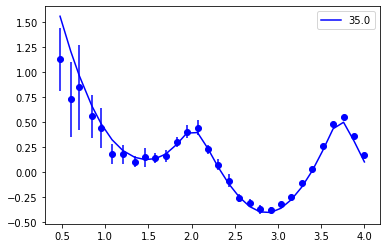

p:  3
p:  4
p:  5
p:  7
p:  9
p:  12
p:  16
p:  22
p:  29
p:  38
p:  50
p:  67
p:  88
p:  117
p:  154
p:  204
p:  269
p:  356
p:  470
p:  621
p:  819
p:  1082
p:  1429
p:  1887
p:  2492
p:  3290
p:  4344
p:  5736
p:  7573
p:  10000

 Time Elapsed: 0h 0m 58s


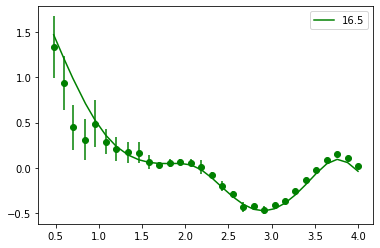

p:  3
p:  4
p:  5
p:  7
p:  9
p:  12
p:  16
p:  22
p:  29
p:  38
p:  50
p:  67
p:  88
p:  117
p:  154
p:  204
p:  269
p:  356
p:  470
p:  621
p:  819
p:  1082
p:  1429
p:  1887
p:  2492
p:  3290
p:  4344
p:  5736
p:  7573
p:  10000

 Time Elapsed: 0h 1m 25s


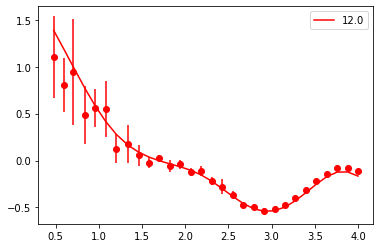

p:  3
p:  4
p:  5
p:  7
p:  9
p:  12
p:  16
p:  22
p:  29
p:  38
p:  50
p:  67
p:  88
p:  117
p:  154
p:  204
p:  269
p:  356
p:  470
p:  621
p:  819
p:  1082
p:  1429
p:  1887
p:  2492
p:  3290
p:  4344
p:  5736
p:  7573
p:  10000

 Time Elapsed: 0h 1m 53s


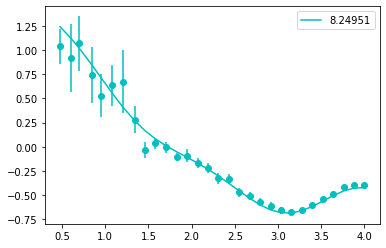

p:  3
p:  4
p:  5
p:  7
p:  9
p:  12
p:  16
p:  22
p:  29
p:  38
p:  50
p:  67
p:  88
p:  117
p:  154
p:  204
p:  269
p:  356
p:  470
p:  621
p:  819
p:  1082
p:  1429
p:  1887
p:  2492
p:  3290
p:  4344
p:  5736
p:  7573
p:  10000

 Time Elapsed: 0h 2m 20s


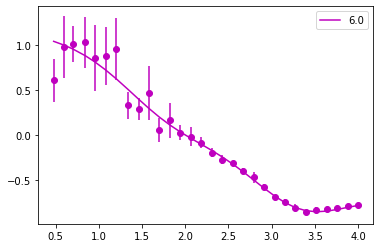

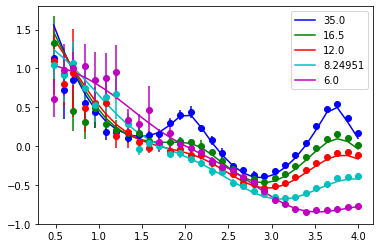

In [5]:
ker_var_alpha_s = np.array([35, 16.5,12,  8.24951, 6])**2
dist_var = 1 # sigma**2 - sample variance
dim = 100
kmax = 50
lamb = 1e-8
noise_var_tilde = 1.25
num_avg = 10 # 100

shift = np.array([0])

pvals = np.logspace(0.5, 4, 30).astype('int')
pteach = 200

theory = Gaussian_theory_and_alphastar(pvals, ker_var_alpha_s, dist_var, dim, kmax, lamb, noise_var_tilde, shift)

errs_tot = theory[0]
errs_tot_asymp = theory[1]
spectrum = theory[2]
degens = theory[3]
alpha = theory[4]
noise = theory[5]

t_start = datetime.now()

all_errs = np.zeros((len(ker_var_alpha_s), len(pvals)))
all_stds = np.zeros((len(ker_var_alpha_s), len(pvals)))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
n_idx = 0
for i in range(len(ker_var_alpha_s)):
    all_errs[i], all_stds[i] = ker_reg.rbf_regression_expt_gpu(pvals, pteach, dim, np.sqrt(dist_var), 
                                                               np.sqrt(ker_var_alpha_s[i]), lamb, num_avg, 
                                                               np.sqrt(noise[i]), errs_tot[i,:,0], num_test = 1000)
    t_end = datetime.now()
    print('\n Time Elapsed: ' + time_diff(t_start,t_end))
    
    norm = spectrum[i,1]**2*degens[1]
    log_p = np.log10(pvals[n_idx:])
    log_err_th = np.log10(errs_tot[i,n_idx:,0]/norm)
    log_err_exp = np.log10(all_errs[i, n_idx:]/norm)
    log_std_exp = all_stds[i, n_idx:]/all_errs[i, n_idx:]/np.sqrt(num_avg)
    
    label_txt = str(np.sqrt(ker_var_alpha_s[i]))
    plt.plot(log_p, log_err_th, label = label_txt, color = colors[i]);
    plt.errorbar(log_p, log_err_exp, log_std_exp, fmt = 'o', color = colors[i])
    plt.legend()
    plt.show()


params = {'ker_var': ker_var_alpha_s, 'dist_var': dist_var, 'kmax': kmax, 'dim': dim, 
          'lamb': lamb, 'noise_var_tilde': noise_var_tilde, 'noise': noise, 
          'spectrum': spectrum, 'alpha': alpha, 'degens': degens,
          'num_avg': num_avg, 'pteach': pteach, 'shift': shift}
  
timestamp = datetime.now().strftime("%m-%d_%H-%M")
if save_data: 
  directory = save_dir + 'GaussianRBF_examples/'
  ensure_dir(directory)
  filename = directory + timestamp + '_error_rbf_prl_fixed_noise.npz'
  np.savez(filename, pvals, errs_tot, errs_tot_asymp, all_errs, all_stds, params) 


colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
n_idx = 0
for i in range(len(ker_var_alpha_s)):
    norm = spectrum[i,1]**2*degens[1]
    
    log_p = np.log10(pvals[n_idx:])
    log_err_th = np.log10(errs_tot[i,n_idx:,0]/norm)
    
    log_err_exp = np.log10(all_errs[i, n_idx:]/norm)
    log_std_exp = all_stds[i, n_idx:]/all_errs[i, n_idx:]/np.sqrt(num_avg)
    
    label_txt = str(np.sqrt(ker_var_alpha_s[i]))
    plt.plot(log_p, log_err_th, label = label_txt, color = colors[i]);
    plt.errorbar(log_p, log_err_exp, log_std_exp, fmt = 'o', color = colors[i])
    plt.legend()

plt.show()
if save_data: 
  plt.savefig(directory + timestamp + '_final_error_curve_fixed_noise' + '.pdf', bbox_inches = 'tight')

# Gaussian RBF Theory/Experiment - Fixed Regularization



p:  3
p:  4
p:  5
p:  7
p:  9
p:  12
p:  16
p:  22
p:  29
p:  38
p:  50
p:  67
p:  88
p:  117
p:  154
p:  204
p:  269
p:  356
p:  470
p:  621
p:  819
p:  1082
p:  1429
p:  1887
p:  2492
p:  3290
p:  4344
p:  5736
p:  7573
p:  10000

 Time Elapsed: 0h 0m 28s
p:  3
p:  4
p:  5
p:  7
p:  9
p:  12
p:  16
p:  22
p:  29
p:  38
p:  50
p:  67
p:  88
p:  117
p:  154
p:  204
p:  269
p:  356
p:  470
p:  621
p:  819
p:  1082
p:  1429
p:  1887
p:  2492
p:  3290
p:  4344
p:  5736
p:  7573
p:  10000

 Time Elapsed: 0h 0m 57s
p:  3
p:  4
p:  5
p:  7
p:  9
p:  12
p:  16
p:  22
p:  29
p:  38
p:  50
p:  67
p:  88
p:  117
p:  154
p:  204
p:  269
p:  356
p:  470
p:  621
p:  819
p:  1082
p:  1429
p:  1887
p:  2492
p:  3290
p:  4344
p:  5736
p:  7573
p:  10000

 Time Elapsed: 0h 1m 26s
p:  3
p:  4
p:  5
p:  7
p:  9
p:  12
p:  16
p:  22
p:  29
p:  38
p:  50
p:  67
p:  88
p:  117
p:  154
p:  204
p:  269
p:  356
p:  470
p:  621
p:  819
p:  1082
p:  1429
p:  1887
p:  2492
p:  3290
p:  4344
p:  5736
p:  7573
p:  

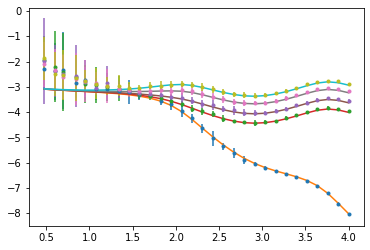

In [6]:
shift = np.array([0])

ker_var = 16.5**2 # gamma**2 - kernel variance
dist_var = 1 # sigma**2 - sample variance
dim = 100
kmax = 50
lamb = 1e-8

spectrum, degens, _ = ker_spec.get_gaussian_spectrum(ker_var, dist_var, kmax, dim)
#spectrum[0] = 0
lambda_bar = spectrum*degens
alpha = (lamb + np.sum(lambda_bar[1:]))/lambda_bar[1]
noise_var = np.array([0, 0.20928716, 0.5, 1.25, 2.5])*spectrum[1]**2*degens[1]

num_avg = 10 # 100
pvals = np.logspace(0.5, 4, 30).astype('int')
pteach = 200

errs_tot = np.zeros((len(shift), len(pvals), len(noise_var)))

for i in range(len(shift)):
    mode_errs, errs_tot[i],_ = ker_sim.simulate_pure_gen_error(pvals, spectrum, degens, noise_var, lamb = lamb)


params = {'ker_var': ker_var, 'dist_var': dist_var, 'kmax': kmax, 'dim': dim, 
          'lamb': lamb, 'noise': noise_var, 
          'spectrum': spectrum, 'alpha': alpha, 'degens': degens,
          'num_avg': num_avg, 'pteach': pteach}

t_start = datetime.now()

all_errs = np.zeros((len(shift), len(noise_var), len(pvals)))
all_stds = np.zeros((len(shift), len(noise_var), len(pvals)))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for i in range(len(shift)):
    for n, noise in enumerate(noise_var):
        all_errs[i,n], all_stds[i,n] = ker_reg.rbf_regression_expt_gpu(pvals, pteach, dim, np.sqrt(dist_var), np.sqrt(ker_var), lamb, 
                                                       num_avg, np.sqrt(noise), errs_tot[i,:,n], num_test = 1000)
        t_end = datetime.now()
        print('\n Time Elapsed: ' + time_diff(t_start,t_end))


for i in range(len(shift)):
    for n, noise in enumerate(noise_var):
        plt.errorbar(np.log10(pvals), np.log10(all_errs[i,n]), all_stds[i,n]/all_errs[i,n], fmt = '.')
        plt.plot(np.log10(pvals), np.log10(errs_tot[i,:,n]))


if save_data:
  directory = 'GaussianRBF_examples/'
  ensure_dir(directory)
  timestamp = datetime.now().strftime("%m-%d_%H-%M")       
  filename = directory + timestamp + '_error_rbf_prl_fixed_alpha.npz'
  np.savez(filename, pvals, errs_tot, all_errs, all_stds, params)
  plt.savefig(directory + timestamp + '_final_error_curve_fix_alpha' + '.pdf', bbox_inches = 'tight')

plt.show()